# Studio di un circuito RLC

Da un progetto di esame del 2022 svolto dallo studente **Giovanni Saturno**.

In questo elaborato si utilizzano le tecniche dell'analisi dei dati per lo studio di un circuito RLC, simulato con il software TINA.

In [1]:
from matplotlib import pyplot as plt
import pandas
import numpy as np
from iminuit import Minuit
from iminuit.cost import LeastSquares
import math

I componenti del circuito sono:

In [2]:
R = 998          # Resitore di 0.998 kOhm
C = 330*10**-9   # Condensatore di 330 nF
L = 0.1          # Induttore da 100 mH
V = 1            # Generatore di ampiezza 1V

Si prelevano i dati e si raccolgono in un file excel, qui importato medianta apposita funzione della libreria pandas.
Le frequenze sono espresse in Hz, le tensioni in V e i tempi in s.

In [3]:
df = pandas.read_csv('data/dati-RLC.csv')
df.head()

,Frequency,V_R,Scala V,Delta t,Scala T
0,1.000000,0.0020,0.001,0.2480,0.040
1,3.019952,0.0062,0.001,0.0820,0.020
2,10.471285,0.0215,0.005,0.0236,0.004
3,20.892961,0.0430,0.010,0.0116,0.002
4,36.307805,0.0750,0.010,0.0066,0.002


I dati del data frame vengono utilizzati per calcolare le grandezze di interesse:
* $V_R$
* $\phi = 2 \pi \frac{\Delta t}{T}$

e le rispettive incertezze.

In [4]:
gain = df['V_R'].values
phase = 2*math.pi*df['Delta t'].values*df['Frequency'].values
freq = df['Frequency'].values
gain

array([0.002 , 0.0062, 0.0215, 0.043 , 0.075 , 0.17  , 0.225 , 0.26  ,
       0.295 , 0.335 , 0.38  , 0.44  , 0.49  , 0.56  , 0.62  , 0.7   ,
       0.77  , 0.84  , 0.9   , 0.94  , 0.98  , 1.    , 0.98  , 0.96  ,
       0.9   , 0.84  , 0.76  , 0.7   , 0.63  , 0.56  , 0.5   , 0.44  ,
       0.39  , 0.34  , 0.3   , 0.26  , 0.195 , 0.15  , 0.114 , 0.076 ,
       0.038 , 0.022 , 0.0144, 0.0032, 0.0016])

Supponendo uniforme la distribuzione di probabilità all'interno dell'intervallo di errore, degli errori andrebbero divisi per un fattore costante $2/\sqrt{12}=1/\sqrt{3}$, che in questo elaborato è omesso per semplicità, in quanto già sappiamo come si riflette sul risultato finale.

In [5]:
err_gain=(0.1*df['Scala V'].values)
err_phase=2*0.1*math.pi*df['Scala T'].values*df['Frequency'].values

Si graficano poi l'ampiezza della tensione ai capi del resistore e la sua fase

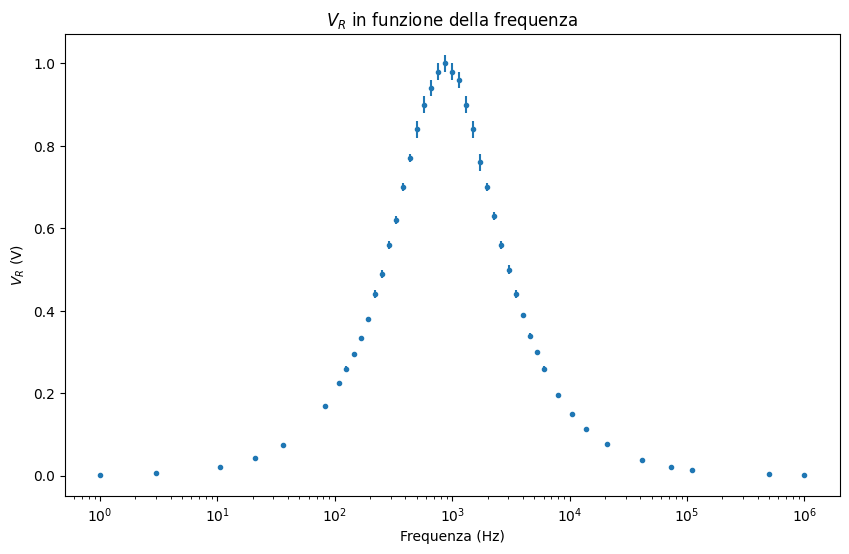

In [6]:
plt.figure(figsize=(10 ,6))
plt.errorbar(freq , gain, err_gain, ls='none', marker=".")
plt.xscale('log')
plt.title('$V_R$ in funzione della frequenza')
plt.xlabel('Frequenza (Hz)')
plt.ylabel('$V_R$ (V)')
plt.show()

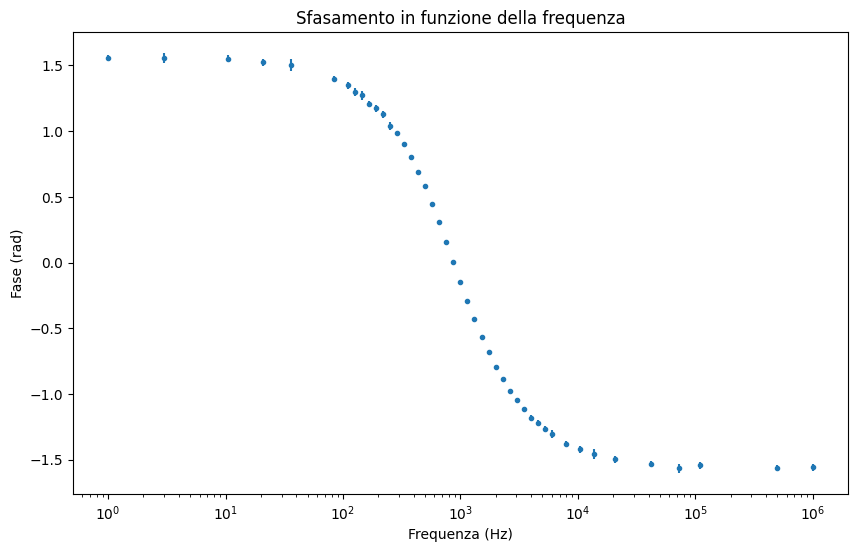

In [7]:
plt.figure(figsize=(10, 6))
plt.errorbar(freq , phase, err_phase, ls='none', marker=".")
plt.xscale('log')
plt.title('Sfasamento in funzione della frequenza')
plt.xlabel('Frequenza (Hz)')
plt.ylabel('Fase (rad)')
plt.show()

Dalla risoluzione teorica del circuito si ricava che la tensione ai capi del resistore è pari a:
$$ V_R = \frac{V_{gen}}{\sqrt{1+ Q^2 \left(\frac{f}{f_0} - \frac{f_0}{f}\right)^2}}$$

In [8]:
def model_ampl(x, *par):
    return V/np.sqrt(1+(((par[0])**2)*(((x/par[1])-(par[1]/x))**2)))

Si effettua, con l'ausilio della libreiria minuit, un fit:

In [9]:
least_squares_mode = LeastSquares(freq, gain, err_gain, model_ampl)
m = Minuit(least_squares_mode, *(0.5, 16000), name=("$Q$", "$f_0$"))
m.limits=((0,100000), (0, 1000000))

In [10]:
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6.026 (χ²/ndof = 0.1)      │              Nfcn = 70               │
│ EDM = 7.33e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ 𝑄    │  0.5522   │  0.0019   │            │            │    0    │ 100000  │       │
│ 1 │ 𝑓₀   │   876.2   │    2.7    │            │            │    0    │  1e+06  │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────┐
│    │        𝑄       𝑓₀ │
├────┼───────────────────┤
│  𝑄 │ 3.52e-06 659.2e-6 │
│ 𝑓₀ │ 659.2e-6     7.39 │
└────┴───────────────────┘

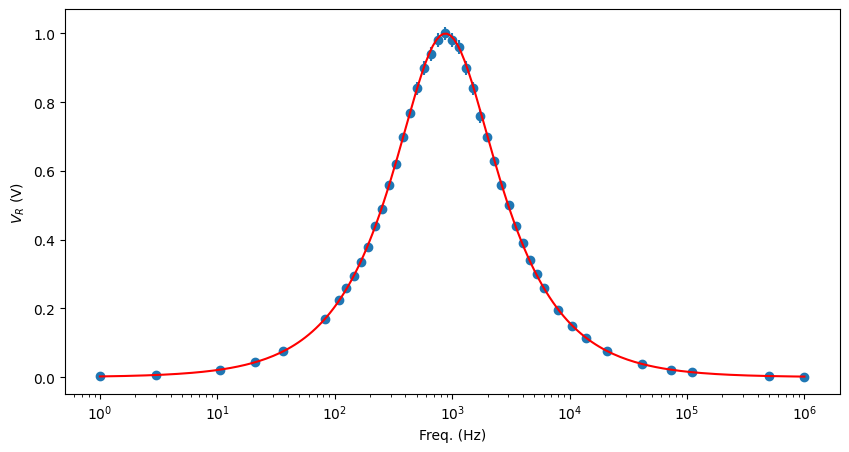

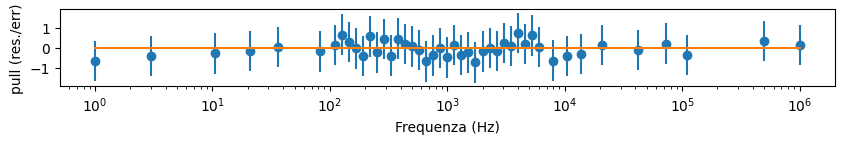

In [11]:
x=np.logspace(0, 6, num=200, base=10.0)
plt.figure(figsize=(10, 5))
plt.plot(x , model_ampl(x, *m.values), color="red", zorder=2)
plt.errorbar(freq, gain, err_gain, ls='none', marker="o", zorder=1)
plt.xscale('log')
plt.xlabel('Freq. (Hz)')
plt.ylabel('$V_R$ (V)')
plt.show()
plt.figure(figsize=(10,1),dpi=100)
plt.errorbar(freq, (gain-model_ampl(freq, *m.values))/err_gain, 1, fmt="o", zorder=1)
plt.plot([freq[0], freq[-1]], [0,0], zorder=2)
plt.xlabel('Frequenza (Hz)')
plt.ylabel('pull (res./err)')
plt.xscale('log')
plt.show()

Dal grafico dei *pull* (= residuo /errore) sembra che gli errori siano stati sovrastimati.

Si ricava quindi una stima della frequenza di risonanza e del fattore di merito.

In [12]:
print("Q = {:.4f} +/- {:.4f}".format(m.values[r"$Q$"], m.errors[r"$Q$"]))
print("f0 = {:.2f} +/- {:.1f}".format(m.values[r"$f_0$"], m.errors[r"$f_0$"]))

Q = 0.5522 +/- 0.0019
f0 = 876.18 +/- 2.7


Si ripete poi lo stesso per la fase utilizzando il modello
$$\phi = -arctan\left(Q \left(\frac{f}{f_0} - \frac{f_0}{f}\right)\right)$$

In [13]:
def model_sfas(x, *par):
    return -np.arctan((((par[0]))*(((x/par[1])-(par[1]/x)))))

In [14]:
least_squares_mode = LeastSquares(freq, phase, err_phase, model_sfas)
m1 = Minuit(least_squares_mode, *(0.5, 16000), name=("$Q$", "$f_0$"))
m1.limits=((0,3), (1, 1000000))

In [15]:
m1.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.896 (χ²/ndof = 0.1)      │              Nfcn = 139              │
│ EDM = 1.29e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ 𝑄    │  0.5518   │  0.0029   │            │            │    0    │    3    │       │
│ 1 │ 𝑓₀   │   876.2   │    0.7    │            │            │    1    │  1e+06  │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────┐
│    │        𝑄       𝑓₀ │
├────┼───────────────────┤
│  𝑄 │ 8.57e-06   234e-6 │
│ 𝑓₀ │   234e-6    0.544 │
└────┴───────────────────┘

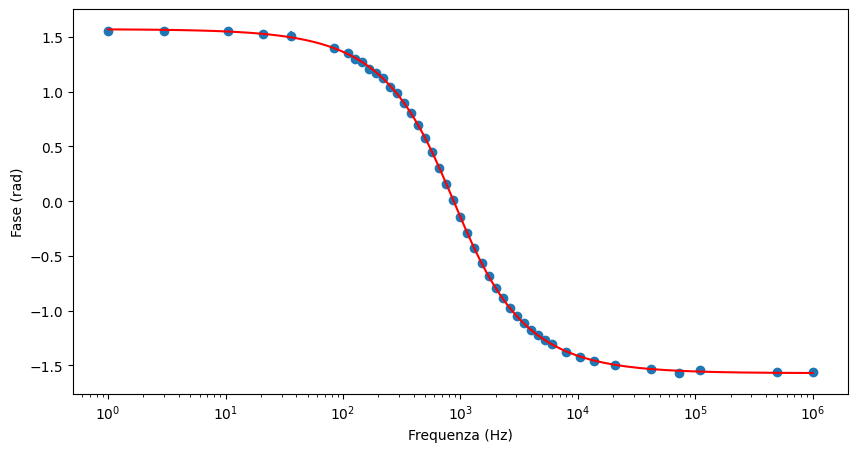

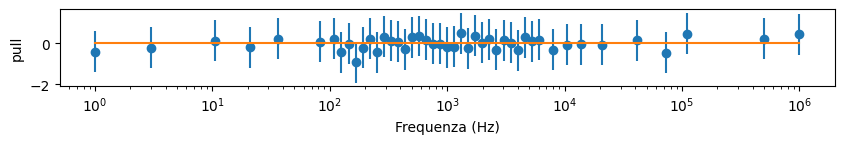

In [16]:
plt.figure(figsize=(10,5))
plt.errorbar(freq , phase, err_phase, ls="none", marker="o", zorder=1)
plt.plot(x , model_sfas(x, *m1.values), color="red", zorder=2)
plt.xscale('log')
plt.xlabel('Frequenza (Hz)')
plt.ylabel('Fase (rad)')
plt.show()
plt.figure(figsize=(10,1),dpi=100)
plt.errorbar(freq, (phase-model_sfas(freq, *m1.values))/err_phase, 1, fmt="o", zorder=1)
plt.plot([freq[0], freq[-1]], [0,0], zorder=2)
plt.xlabel('Frequenza (Hz)')
plt.ylabel('pull')
plt.xscale('log')
plt.show()

Dal fit ricaviamo che:

In [17]:
print("Q = {:.4f} +/- {:.4f}".format(m1.values[r"$Q$"], m1.errors[r"$Q$"]))
print("f0 = {:.2f} +/- {:.1f}".format(m1.values[r"$f_0$"], m1.errors[r"$f_0$"]))

Q = 0.5518 +/- 0.0029
f0 = 876.18 +/- 0.7


Confrontiamo le stime dei parametri ottenuti dai due adattamenti:

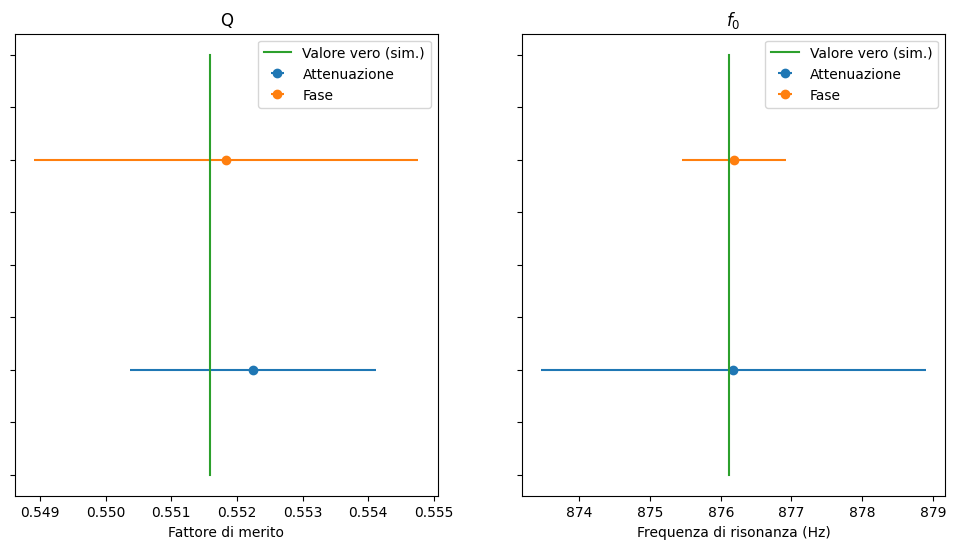

In [18]:
f0 = 1/((2*math.pi)*math.sqrt(L*C))
Q = 1/R*math.sqrt(L/C)

f  = plt.figure(figsize=(12,6))
a1 = plt.subplot(1,2,1)
a2 = plt.subplot(1,2,2)

a2.set_yticklabels(()),a1.set_yticklabels(())
a1.set_title("Q")
a2.set_title("$f_0$")
a1.errorbar(m.values[0] , 0, yerr=None, xerr=m.errors[0], ls="none", marker="o", zorder=1, label="Attenuazione")
a1.errorbar(m1.values[0] , 1, yerr=None, xerr=m1.errors[0], ls="none", marker="o", zorder=1, label="Fase")
a1.plot([Q,Q], [-0.5, 1.5], label="Valore vero (sim.)")
a1.set_xlabel('Fattore di merito')
a1.legend()
a2.errorbar(m.values[1] , 0, yerr=None, xerr=m.errors[1], ls="none", marker="o", zorder=1, label="Attenuazione")
a2.errorbar(m1.values[1] , 1, yerr=None, xerr=m1.errors[1], ls="none", marker="o", zorder=1, label="Fase")
a2.plot([f0, f0], [-0.5, 1.5], label="Valore vero (sim.)")
a2.set_xlabel('Frequenza di risonanza (Hz)')
a2.legend()
plt.show()


Notiamo che con un fit della fase si ottiene una stima più accurata della frequenza di risonanza, mentre con quella della tensione ai capi del resistore è privilegiato il fattore di merito.
Si prova poi con un fit simultaneo per stimare i due parametri di interesse:

In [19]:
combo_x = np.append(freq, freq)
combo_y = np.append(gain, phase)
def combo_func(combo_data, *param):
    # single data set passed in, extract separate data
    extract1 = combo_data[:len(gain)] # first data
    extract2 = combo_data[len(phase):] # second data
    result1 = model_ampl(extract1, *param)
    result2 = model_sfas(extract2, *param)
    return np.append(result1, result2)

least_squares_mode = LeastSquares(combo_x, combo_y, np.append(err_gain, err_phase), combo_func)
mt = Minuit(least_squares_mode, *(0.5, 16000), name=("$Q$", "${f}_0$"))
mt.limits=((0,100000), (0, 1000000))
mt.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 9.936 (χ²/ndof = 0.1)      │              Nfcn = 81               │
│ EDM = 1.78e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ 𝑄    │  0.5521   │  0.0016   │            │            │    0    │ 100000  │       │
│ 1 │ 𝑓₀   │   876.2   │    0.7    │            │            │    0    │  1e+06  │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────┐
│    │        𝑄       𝑓₀ │
├────┼───────────────────┤
│  𝑄 │ 2.47e-06  94.6e-6 │
│ 𝑓₀ │  94.6e-6    0.504 │
└────┴───────────────────┘

Si confronta il risultato ottenuto con i precedenti

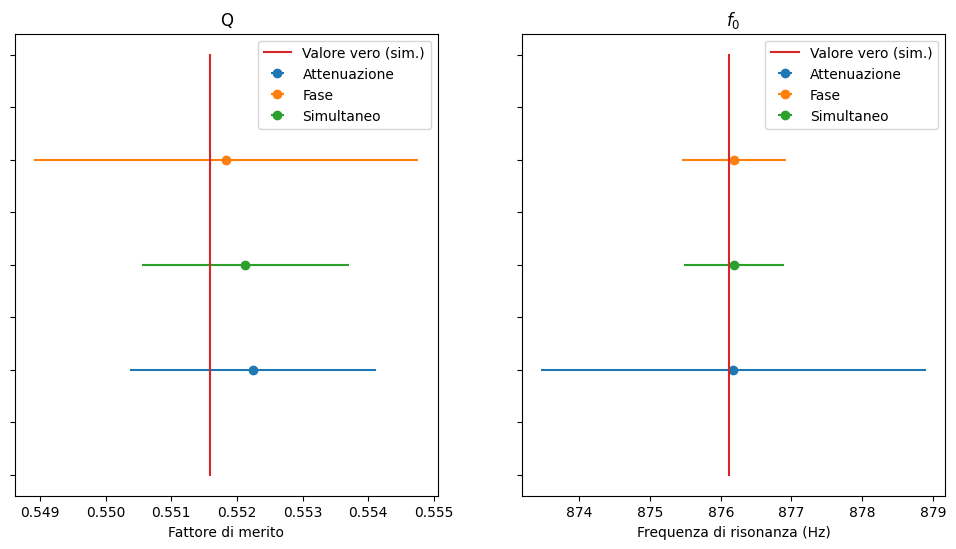

In [20]:
f  = plt.figure(figsize=(12,6))
a1 = plt.subplot(1,2,1)
a2 = plt.subplot(1,2,2)

a2.set_yticklabels(()),a1.set_yticklabels(())
a1.set_title("Q")
a2.set_title("$f_0$")
a1.errorbar(m.values[0] , 0, yerr=None, xerr=m.errors[0], ls="none", marker="o", zorder=1, label="Attenuazione")
a1.errorbar(m1.values[0] , 1, yerr=None, xerr=m1.errors[0], ls="none", marker="o", zorder=1, label="Fase")
a1.errorbar(mt.values[0] , 0.5, yerr=None, xerr=mt.errors[0], ls="none", marker="o", zorder=1, label="Simultaneo")
a1.plot([Q,Q], [-0.5, 1.5], label="Valore vero (sim.)")
a1.legend()
a1.set_xlabel('Fattore di merito')
a2.errorbar(m.values[1] , 0, yerr=None, xerr=m.errors[1], ls="none", marker="o", zorder=1, label="Attenuazione")
a2.errorbar(m1.values[1] , 1, yerr=None, xerr=m1.errors[1], ls="none", marker="o", zorder=1, label="Fase")
a2.errorbar(mt.values[1] , 0.5, yerr=None, xerr=mt.errors[1], ls="none", marker="o", zorder=1, label="Simultaneo")
a2.plot([f0, f0], [-0.5, 1.5], label="Valore vero (sim.)")
a2.set_xlabel('Frequenza di risonanza (Hz)')
a2.legend()
plt.show()

Come cambia la situazione considerando anche $V_{gen}$ come un parametro?

In [21]:
#Lasciamo libera la costante di normailzzazione
def model_ampl1(x, *par):
    return par[0]/np.sqrt(1+(((par[1])**2)*(((x/par[2])-(par[2]/x))**2)))

In [22]:
least_squares_mode = LeastSquares(freq, gain, err_gain, model_ampl1)
ia = Minuit(least_squares_mode, *(1,0.5, 16000), name=("A","$Q$", "${f}_0$"))
ia.limits=((0,1),(0,100000), (0, 1000000))
ia.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.758 (χ²/ndof = 0.1)      │              Nfcn = 288              │
│ EDM = 7.03e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │   0.996   │   0.007   │            │            │    0    │    1    │       │
│ 1 │ 𝑄    │   0.550   │   0.005   │            │            │    0    │ 100000  │       │
│ 2 │ 𝑓₀   │   876.1   │    2.7    │            │            │    0    │  1e+06  │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬────────────────────────────┐
│    │        A        𝑄       𝑓₀ │
├────┼────────────────────────────┤
│  A │ 4.83e-05 0.031e-3  1.42e-3 │
│  𝑄 │ 0.031e-3 2.36e-05 1.577e-3 │
│ 𝑓₀ │  1.42e-3 1.577e-3     7.45 │
└────┴────────────────────────────┘

In [23]:
combo_x1 = np.append(freq, freq)
combo_y1 = np.append(gain, phase)

def combo_func1(combo_data, *param):
    # single data set passed in, extract separate data
    extract1 = combo_data[:len(gain)] # first data
    extract2 = combo_data[len(phase):] # second data

    result1 = model_ampl1(extract1, *param)
    result2 = model_sfas(extract2, *(param[1:]))

    return np.append(result1, result2)

least_squares_mode = LeastSquares(combo_x1, combo_y1, np.append(err_gain, err_phase), combo_func1)
g1 = Minuit(least_squares_mode, *(0.996, 0.545, 800), name=("A", "$Q$", "${f}_0$"))
g1.limits=((0,1.5), (0,10), (1, 200000))
g1.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 9.769 (χ²/ndof = 0.1)      │              Nfcn = 76               │
│ EDM = 2.59e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │   0.998   │   0.004   │            │            │    0    │   1.5   │       │
│ 1 │ 𝑄    │  0.5513   │  0.0025   │            │            │    0    │   10    │       │
│ 2 │ 𝑓₀   │   876.2   │    0.7    │            │            │    1    │ 200000  │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬────────────────────────────┐
│    │        A        𝑄       𝑓₀ │
├────┼────────────────────────────┤
│  A │ 1.81e-05     8e-6 0.204e-3 │
│  𝑄 │     8e-6 6.27e-06   188e-6 │
│ 𝑓₀ │ 0.204e-3   188e-6    0.507 │
└────┴────────────────────────────┘

I risultati ottenuti sono confrontati con i precedenti

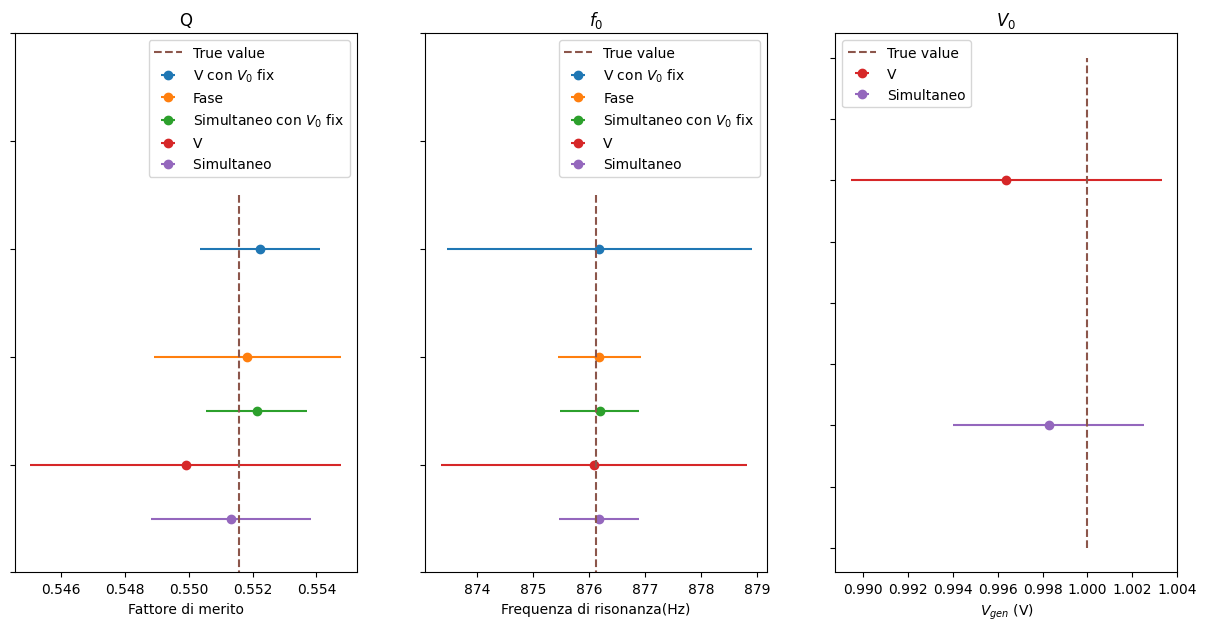

In [24]:
f  = plt.figure(figsize=(15,7))
a1 = plt.subplot(1,3,1)
a2 = plt.subplot(1,3,2)
a3 = plt.subplot(1,3,3)
f0 = 1/((2*math.pi)*math.sqrt(L*C))
Q = 1/R*math.sqrt(L/C)

a3.set_yticklabels(()),a2.set_yticklabels(()),a1.set_yticklabels(())
a2.set_ylim(3, -2), a1.set_ylim(3, -2)
a1.set_title("Q")
a2.set_title("$f_0$")
a1.errorbar(m.values[0] , 0, yerr=None, xerr=m.errors[0], ls="none", marker="o", zorder=1, label="V con $V_0$ fix")
a1.errorbar(m1.values[0] , 1, yerr=None, xerr=m1.errors[0], ls="none", marker="o", zorder=1, label="Fase")
a1.errorbar(mt.values[0] , 1.5, yerr=None, xerr=mt.errors[0], ls="none", marker="o", zorder=1, label="Simultaneo con $V_0$ fix")
a1.errorbar(ia.values[1] , 2, yerr=None, xerr=ia.errors[1], ls="none", marker="o", zorder=1, label="V ")
a1.errorbar(g1.values[1] , 2.5, yerr=None, xerr=g1.errors[1], ls="none", marker="o", zorder=1, label="Simultaneo ")
a1.plot([Q,Q], [-0.5, 4], linestyle='--', label='True value')
a1.legend()
a2.errorbar(m.values[1] , 0, yerr=None, xerr=m.errors[1], ls="none", marker="o", zorder=1, label="V con $V_0$ fix")
a2.errorbar(m1.values[1] , 1, yerr=None, xerr=m1.errors[1], ls="none", marker="o", zorder=1, label="Fase")
a2.errorbar(mt.values[1] , 1.5, yerr=None, xerr=mt.errors[1], ls="none", marker="o", zorder=1, label="Simultaneo con $V_0$ fix")
a2.errorbar(ia.values[2] , 2, yerr=None, xerr=ia.errors[2], ls="none", marker="o", zorder=1, label="V")
a2.errorbar(g1.values[2] , 2.5, yerr=None, xerr=g1.errors[2], ls="none", marker="o", zorder=1, label="Simultaneo")
a2.plot([f0, f0], [-0.5, 3], linestyle='--', label='True value')
a3.errorbar(ia.values[0] , 1, yerr=None, xerr=ia.errors[0], ls="none", marker="o", zorder=1, label="V", color='#d62728')
a3.errorbar(g1.values[0] , 0, yerr=None, xerr=g1.errors[0], ls="none", marker="o", zorder=1, label="Simultaneo", color='#9467bd')
a3.set_title("$V_0$")
a3.plot([1,1], [-0.5, 1.5], linestyle='--', label='True value', color='#8c564b')
a2.legend()
a3.legend()
a1.set_xlabel('Fattore di merito')
a2.set_xlabel('Frequenza di risonanza(Hz)')
a3.set_xlabel('$V_{gen}$ (V)')
plt.show()